In [6]:
from typing import Annotated
from typing_extensions import TypedDict

# Langchain/graph modules
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

# Import Model
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

# Import environment variables
from dotenv import load_dotenv
load_dotenv()

# Import visualization library
from IPython.display import Image,display

## State Graph initlization
## Typed Dict Initialization
## Invoke LLM and verify chatbout output

In [7]:
# Define Class state for messages
class State(TypedDict):
    messages:Annotated[list,add_messages]

# testing node functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

llm = ChatGroq(model="llama3-8b-8192")
print(llm)

client=<groq.resources.chat.completions.Completions object at 0x0000016ACA850A50> async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000016ACA851450> model_name='llama3-8b-8192' model_kwargs={} groq_api_key=SecretStr('**********')


In [8]:
graph_builder = StateGraph(State)

# Adding node
graph_builder.add_node("tool-llmchat", chatbot) 

# Adding Edges
graph_builder.add_edge(START,"tool-llmchat")
graph_builder.add_edge("tool-llmchat", END)

# Compile The graph
graph = graph_builder.compile(name="Agent_test")

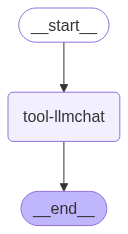

In [9]:
try:
    img = display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Visualization not supported in this environment.")

In [10]:
response = graph.invoke({"messages": "Hi"})


In [11]:
response["messages"]

[HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='aec64a03-fe04-4a28-a66f-f914cae082c1'),
 AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.055208812, 'prompt_time': 0.005964842, 'queue_time': 0.06257312300000001, 'total_time': 0.061173654}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--8ac20c3c-2c77-4117-bef4-ba8384cdf845-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})]

In [12]:
response["messages"][-1]

AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.055208812, 'prompt_time': 0.005964842, 'queue_time': 0.06257312300000001, 'total_time': 0.061173654}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--8ac20c3c-2c77-4117-bef4-ba8384cdf845-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})

In [13]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

## Tool Integration test

In [14]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - GeeksforGeeks',
   'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
   'content': 'LangGraph is a Python library that helps you build applications like chatbots or AI agents by organizing their logic step-by-step using state machine model. This step configures your Gemini API key and then we create a simple function ask_gemini that takes user input, sends it to the Gemini model and returns the AI-generated response. Creates a state structure with three fields: question, classification and response which flows through the LangGraph. import matplotlib.pyplot as plt from langgraph.graph import StateGraph\u200bbuilder = StateGraph(GraphState)builder.add_node("classify", classify)builder.add_node("respond", respond)builder.set_entry_point("classify")builder.add_edge("classify", "respond")builder.set_finish_point("respond")app = 

## Create a custom function/tool that the llm can call

In [15]:
def multiply(a:int,b:int) -> int:
    """Multily a and b
    Args:
    a (int): first int
    b (int): second int

    Returns:
    int: output int
    """

In [16]:
tools = [tool,multiply]

In [17]:
llm_with_tool = llm.bind_tools(tools)

In [18]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000016ACA850A50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000016ACA851450>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

In [ ]:
## State graph
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## graph defination

builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If latest message (result) from assistant is a tool call --> ttols condition routes to tools
    # If latest message (result) from assistant is not a tool call --> ttols condition routes to END
    tools_condition
)
builder.add_edge("tools", END)

## Compile the Graph
graph = builder.compile()

try:
    img = display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("NULL")